In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xrft
import cartopy.crs as ccrs
from cmocean import cm
import h5py

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(5)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.1.60:41917 Dashboard: http://10.148.1.60:8787/status,Cluster Workers: 10 Cores: 40 Memory: 500.00 GB


---


# 1. Drifter data files

In [7]:
# The processed data set only includes Argos-tracked surface drifters.
# 2-month blocks with overlapping by 50%

data_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'
drifter_dataset = h5py.File(data_dir+'Drifter_dataset_processed_Argos_only.mat','r') 
list(drifter_dataset.items())

# mlat2: mean latitude every 60 days,     132970*1
# mlon2: mean longitude every 60 days,    132970*1

# qd: drogued drifters,                  132970*1
# qu: undrogued drifters,                132970*1
# qmedxxx: median water depth > xxx m,   132970*1

# uv2: (u, v),                           132970*1440

[('dpth2', <HDF5 dataset "dpth2": shape (132970, 1440), type "<f8">),
 ('lat2_err', <HDF5 dataset "lat2_err": shape (132970, 1440), type "<f8">),
 ('lon2_err', <HDF5 dataset "lon2_err": shape (132970, 1440), type "<f8">),
 ('mdpth', <HDF5 dataset "mdpth": shape (132970, 1), type "<f8">),
 ('mlat2', <HDF5 dataset "mlat2": shape (132970, 1), type "<f8">),
 ('mlon2', <HDF5 dataset "mlon2": shape (132970, 1), type "<f8">),
 ('qall1000', <HDF5 dataset "qall1000": shape (132970, 1), type "|u1">),
 ('qall200', <HDF5 dataset "qall200": shape (132970, 1), type "|u1">),
 ('qall500', <HDF5 dataset "qall500": shape (132970, 1), type "|u1">),
 ('qd', <HDF5 dataset "qd": shape (132970, 1), type "|u1">),
 ('qmed1000', <HDF5 dataset "qmed1000": shape (132970, 1), type "|u1">),
 ('qmed200', <HDF5 dataset "qmed200": shape (132970, 1), type "|u1">),
 ('qmed500', <HDF5 dataset "qmed500": shape (132970, 1), type "|u1">),
 ('qu', <HDF5 dataset "qu": shape (132970, 1), type "|u1">),
 ('u2_err', <HDF5 dataset

In [8]:
# turn mean-lat into xarray_DataArray
lat2 = drifter_dataset['mlat2']
lat2 = np.array(lat2)
lat = xr.DataArray(lat2, dims=['lat', 'none'])
lat = xr.DataArray.squeeze(lat, dim='none')
lat = np.real(lat).rename('lat')
lat

<xarray.DataArray 'lat' (lat: 132970)>
array([ 44.219853,  44.908928,  44.856863, ..., -12.761236, -12.266537,
       -12.920261])
Dimensions without coordinates: lat

In [9]:
# turn mean-lon into xarray_DataArray
lon2 = drifter_dataset['mlon2']
lon2 = np.array(lon2)
lon = xr.DataArray(lon2, dims=['lon', 'none'])
lon = xr.DataArray.squeeze(lon, dim='none')
lon = np.real(lon).rename('lon')
lon

<xarray.DataArray 'lon' (lon: 132970)>
array([307.992707, 306.962722, 305.597501, ..., 186.569928, 185.446468,
       183.725235])
Dimensions without coordinates: lon

In [10]:
# turn drogued_information into xarray_DataArray
qd = drifter_dataset['qd']
qd = np.array(qd)
qd = xr.DataArray(qd, dims=['qd', 'none'])
qd = xr.DataArray.squeeze(qd, dim='none')
qd = np.real(qd).rename('qd')
qd

<xarray.DataArray 'qd' (qd: 132970)>
array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)
Dimensions without coordinates: qd

In [11]:
# (u,v) --> u+iv
uv = drifter_dataset['uv2'].value.view(np.double).reshape((132970, 1440, 2))
uv_drifters = uv[:,:,0] + 1j*uv[:,:,1]
uv_drifters.shape  # result is (10, 10, 10)
uv_drifters

array([[-2.048e-01+0.4936j, -3.023e-01+0.4859j, -2.971e-01+0.4856j, ...,
         1.322e-01+0.009j ,  1.219e-01-0.0239j, -8.050e-02-0.1172j],
       [ 1.436e-01+0.2085j,  1.056e-01+0.1783j,  3.870e-02+0.128j , ...,
         1.160e-01+0.075j ,  7.790e-02+0.2255j,  1.379e-01+0.195j ],
       [-1.518e-01-0.1663j, -1.137e-01-0.1704j, -1.083e-01-0.1446j, ...,
        -2.145e-01-0.3872j, -2.150e-01-0.3862j, -2.145e-01-0.3976j],
       ...,
       [-7.100e-03+0.0769j, -6.200e-03+0.0766j, -7.300e-03+0.0763j, ...,
        -1.323e-01+0.3752j, -8.730e-02+0.3766j, -9.530e-02+0.1764j],
       [-9.000e-04-0.0386j,  3.000e-04-0.0347j, -3.830e-02-0.0921j, ...,
        -5.182e-01-0.1748j, -4.973e-01-0.2009j, -1.785e-01-0.1901j],
       [-9.570e-02+0.1772j, -9.580e-02+0.1778j, -9.550e-02+0.1787j, ...,
        -4.356e-01+0.247j , -4.677e-01+0.1324j, -4.667e-01+0.1318j]])

In [12]:
# Drifter Dataset (u+iv,lat,lon,time,qd)
ds = xr.Dataset({'uv_drifters': (['lat', 'time'], uv_drifters)},
                
                 coords={'lat': (['lat'], lat),
                         'lon': (['lat'], lon),
                         'time':(['time'], np.arange(1440)*3600),
                         'qd':(['lat'], qd)})
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:      (lat: 132970, time: 1440)
Coordinates:
  * lat          (lat) float64 44.22 44.91 44.86 43.76 42.22 46.44 46.08 ...
    lon          (lat) float64 308.0 307.0 305.6 305.5 309.8 307.8 307.6 ...
  * time         (time) int64 0 3600 7200 10800 14400 18000 21600 25200 ...
    qd           (lat) uint8 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 ...
Data variables:
    uv_drifters  (lat, time) complex128 (-0.2048+0.4936j) (-0.3023+0.4859j) ...

 data size: 3.1 GB


_________
# 2. Rotary spectra of drifter uv

## linear detrend and Hanning window

In [28]:
uv_fft_complex = xrft.dft(ds.uv_drifters.where((ds.qd>0) & (ds.lat<62) & (ds.lat>7) & (ds.lon<360) & (ds.lon>263)).fillna(0.), dim=['time'], shift=False, detrend='constant', window=True, chunks_to_segments=False)
E_uv_blocks = (uv_fft_complex*uv_fft_complex.conj()).where(uv_fft_complex!=0., drop=False)/1440*3600
E_uv_blocks = np.real(E_uv_blocks).rename('E_uv_blocks')
E_uv_blocks = E_uv_blocks.assign_coords(freq_cpd=E_uv_blocks.freq_time * 86400.) 
print(E_uv_blocks)
file_E = data_dir+'E_drifter_uv_qd_blocks_Argos_North_Atlantic.zarr'
%time E_uv_blocks.to_dataset().to_zarr(file_E, mode='w')  

<xarray.DataArray 'E_uv_blocks' (lat: 132970, freq_time: 1440)>
array([[  41.449042,  224.213051,   18.733901, ...,   71.052559,  368.85104 ,
        1040.178246],
       [  71.514198,   78.044782,  180.974461, ...,  381.753522,  765.643948,
         319.976326],
       [ 536.502997, 2588.617917, 1703.104273, ...,   42.542534,  382.064573,
          64.560797],
       ...,
       [        nan,         nan,         nan, ...,         nan,         nan,
                nan],
       [        nan,         nan,         nan, ...,         nan,         nan,
                nan],
       [        nan,         nan,         nan, ...,         nan,         nan,
                nan]])
Coordinates:
  * lat                (lat) float64 44.22 44.91 44.86 43.76 42.22 46.44 ...
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
    freq_time_spacing  float64 1.929e-07
    freq_cpd           (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
CPU times: user 1.22 s, sys: 14

In [24]:
uv_fft_complex = xrft.dft(ds.uv_drifters.where((ds.qd>0) & (ds.lat<62) & (ds.lat>7) & (ds.lon<360) & (ds.lon>263)).fillna(0.), dim=['time'], shift=False, detrend='constant', window=True, chunks_to_segments=False)

E_uv_blocks = (uv_fft_complex*uv_fft_complex.conj()).where(uv_fft_complex!=0., drop=False)/1440*3600
E_uv_blocks = np.real(E_uv_blocks).rename('E_uv_blocks')
E_uv_blocks = E_uv_blocks.assign_coords(freq_cpd=E_uv_blocks.freq_time * 86400.) 
E_uv_zonmean = (E_uv_blocks.groupby_bins(E_uv_blocks.lat, np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['lat']))

E_drifter_linear_window = E_uv_zonmean
E_drifter_linear_window = np.real(E_drifter_linear_window).rename('E_drifter_linear_window')
file_E = data_dir+'E_drifter_linear_window_Argos_only_North_Atlantic.zarr'
%time E_drifter_linear_window.to_dataset().to_zarr(file_E, mode='w')  

CPU times: user 908 ms, sys: 32 ms, total: 940 ms
Wall time: 34.2 ms


# 3. Latitude-resolved spectra

In [25]:
data_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'
ds_linear_window = xr.open_zarr(data_dir+'E_drifter_linear_window_Argos_only_North_Atlantic.zarr').chunk({'freq_time': 1440, 'lat_bins': 1}) 
E_drifter = ds_linear_window.E_drifter_linear_window

Text(0.5,1,'Drifter')

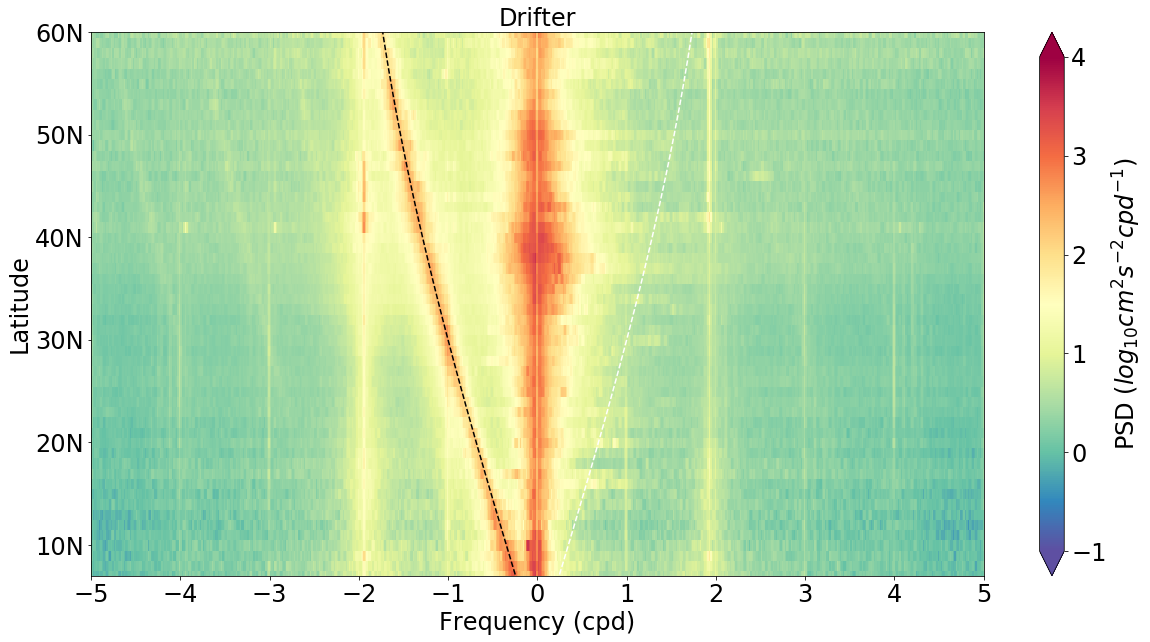

In [27]:
plt.figure(figsize=(20,10))
ax = plt.subplot(1,1,1)

cax = np.log10(E_drifter.sortby('freq_time')/8.64).plot.pcolormesh(ax=ax, vmin=-1., vmax=4, x='freq_cpd', y='lat_bins', cmap = 'Spectral_r', add_colorbar = False)

# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=24)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=24)
            
# x,y ticks
#ax.set_xticks([-12., -10., -8., -6., -4., -2., 0, 2., 4., 6., 8., 10., 12.])
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
#ax.set_xlim(-12., 12.)
ax.set_xlim(-5., 5.)
ax.set_ylim(7., 60.)
ax.set_yticks([10., 20., 30, 40., 50, 60.])
ax.set_yticklabels(['10N','20N','30N','40N','50N','60N'])
ax.set_ylabel('Latitude',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)

# add coriolis frequency
f_drifter = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_drifter.lat_bins))
ax.plot(f_drifter*86400./2./np.pi,f_drifter.lat_bins,'w--')
ax.plot(-f_drifter*86400./2./np.pi,f_drifter.lat_bins,'k--')
ax.set_title('Drifter',fontsize=24)

#plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_lat_Drifter.png')


In [29]:
data_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'
ds = xr.open_zarr(data_dir+'E_drifter_uv_qd_blocks_Argos_North_Atlantic.zarr').chunk({'freq_time': 1440,'lat': 1000}) 
E_uv_blocks = ds.E_uv_blocks
print(ds)

<xarray.Dataset>
Dimensions:            (freq_time: 1440, lat: 132970)
Coordinates:
    freq_cpd           (freq_time) float64 dask.array<shape=(1440,), chunksize=(1440,)>
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
    freq_time_spacing  float64 ...
  * lat                (lat) float64 44.22 44.91 44.86 43.76 42.22 46.44 ...
Data variables:
    E_uv_blocks        (lat, freq_time) float64 dask.array<shape=(132970, 1440), chunksize=(1000, 1440)>


In [30]:
df = E_uv_blocks.freq_time[1] - E_uv_blocks.freq_time[0]
print(df)

<xarray.DataArray 'freq_time' ()>
array(1.929012e-07)
Coordinates:
    freq_time_spacing  float64 1.929e-07


In [31]:
f_drifter = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_uv_blocks.lat))
f_cpd_drifter = f_drifter*86400/2./np.pi

In [32]:
E_semi = (E_uv_blocks.where((abs(E_uv_blocks.freq_cpd)>1.9) & (abs(E_uv_blocks.freq_cpd)<2.1) , other=0.)*df).sum(dim='freq_time')
E_semi = np.real(E_semi).rename('E_semi')

E_diurnal = (E_uv_blocks.where((abs(E_uv_blocks.freq_cpd)>0.9) & (abs(E_uv_blocks.freq_cpd)<1.1) , other=0.)*df).sum(dim='freq_time')
E_diurnal = np.real(E_diurnal).rename('E_diurnal')

E_high = (E_uv_blocks.where((abs(E_uv_blocks.freq_cpd)>=0.5), other=0.)*df).sum(dim='freq_time')
E_high  = np.real(E_high).rename('E_high')

E_f = (E_uv_blocks.where((abs(E_uv_blocks.freq_cpd+f_cpd_drifter)<0.1), other=0.)*df).sum(dim='freq_time')
E_f = np.real(E_f).rename('E_f')

In [33]:
E_drifter = xr.merge([E_semi.to_dataset(), E_diurnal.to_dataset(), E_high.to_dataset(), E_f.to_dataset()])
file_E = data_dir+'E_drifter_Argos_North_Atlantic.nc'
%time E_drifter.to_netcdf(file_E, mode='w')  

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/worker.py:820: UserWarning: Large object of size 1.22 MB detected in task graph: 
  ("('__array_wrap__-651a36501dc8f795f5fe0d2cdabd5e5 ... a470>]), False)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s))


CPU times: user 10.2 s, sys: 1.16 s, total: 11.3 s
Wall time: 25.7 s


In [28]:
uv_fft_complex = xrft.dft(ds.uv_drifters.where((ds.qd>0) & (ds.lat<62) & (ds.lat>7) & (ds.lon<360) & (ds.lon>263)).fillna(0.), dim=['time'], shift=False, detrend='constant', window=True, chunks_to_segments=False)
E_uv_blocks = (uv_fft_complex*uv_fft_complex.conj()).where(uv_fft_complex!=0., drop=False)/1440*3600
E_uv_blocks = np.real(E_uv_blocks).rename('E_uv_blocks')
E_uv_blocks = E_uv_blocks.assign_coords(freq_cpd=E_uv_blocks.freq_time * 86400.) 
print(E_uv_blocks)
file_E = data_dir+'E_drifter_uv_qd_blocks_Argos_North_Atlantic.zarr'
%time E_uv_blocks.to_dataset().to_zarr(file_E, mode='w')  

<xarray.DataArray 'E_uv_blocks' (lat: 132970, freq_time: 1440)>
array([[  41.449042,  224.213051,   18.733901, ...,   71.052559,  368.85104 ,
        1040.178246],
       [  71.514198,   78.044782,  180.974461, ...,  381.753522,  765.643948,
         319.976326],
       [ 536.502997, 2588.617917, 1703.104273, ...,   42.542534,  382.064573,
          64.560797],
       ...,
       [        nan,         nan,         nan, ...,         nan,         nan,
                nan],
       [        nan,         nan,         nan, ...,         nan,         nan,
                nan],
       [        nan,         nan,         nan, ...,         nan,         nan,
                nan]])
Coordinates:
  * lat                (lat) float64 44.22 44.91 44.86 43.76 42.22 46.44 ...
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
    freq_time_spacing  float64 1.929e-07
    freq_cpd           (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
CPU times: user 1.22 s, sys: 14

_________
# 4. Drifter globally-averaged spectra

## need to change file names to get all, undrogued and drogued results

In [34]:
data_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'
ds = xr.open_zarr(data_dir+'E_drifter_uv_qd_blocks_Argos_North_Atlantic.zarr').chunk({'freq_time': 1440,'lat': 1000}) 
E_uv_blocks = ds.E_uv_blocks
print(ds)

<xarray.Dataset>
Dimensions:            (freq_time: 1440, lat: 132970)
Coordinates:
    freq_cpd           (freq_time) float64 dask.array<shape=(1440,), chunksize=(1440,)>
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
    freq_time_spacing  float64 ...
  * lat                (lat) float64 44.22 44.91 44.86 43.76 42.22 46.44 ...
Data variables:
    E_uv_blocks        (lat, freq_time) float64 dask.array<shape=(132970, 1440), chunksize=(1000, 1440)>


In [41]:
# cyclonic spectra
E_uv_1 = ((E_uv_blocks).where( (E_uv_blocks.lat>0.) & (E_uv_blocks.freq_time>0.) )).mean(dim=('lat'))   
E_uv_1 = np.real(E_uv_1).rename('E_uv_1')
E_uv_1 


E_drifter_cycl = (E_uv_1)/8.64 #(unit:cm^2 s^-2/cpd)
E_drifter_cycl = E_drifter_cycl.assign_coords(freq_time=E_drifter_cycl.freq_time * 86400.) 
E_drifter_cycl

<xarray.DataArray 'E_uv_1' (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
    freq_cpd           (freq_time) float64 dask.array<shape=(1440,), chunksize=(1440,)>
  * freq_time          (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 1.929e-07

In [47]:
# anti-cyclonic spectra

E_uv_4 = ((E_uv_blocks).where( (E_uv_blocks.lat>0.) & (E_uv_blocks.freq_time<0.) )).mean(dim=('lat'))   
E_uv_4 = E_uv_4.assign_coords(freq_time=E_uv_4.freq_time * 1.) 
E_uv_4 = np.real(E_uv_4).rename('E_uv_4')
E_uv_4 

E_drifter_anti = (E_uv_4)/8.64 #(unit:cm^2 s^-2/cpd)
E_drifter_anti = E_drifter_anti.assign_coords(freq_time=E_drifter_anti.freq_time * 86400.) 
E_drifter_anti

<xarray.DataArray 'E_uv_4' (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
    freq_cpd           (freq_time) float64 dask.array<shape=(1440,), chunksize=(1440,)>
  * freq_time          (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 1.929e-07

In [48]:
E_drifter_cycl = np.real(E_drifter_cycl).rename('E_drifter_cycl')
E_drifter_anti = np.real(E_drifter_anti).rename('E_drifter_anti')
E_drifter_globalmean = xr.merge([E_drifter_anti.to_dataset(), E_drifter_cycl.to_dataset()])
print(E_drifter_globalmean)
file_E = data_dir+'E_drifter_qd_North_Atlantic_mean.zarr'
%time E_drifter_globalmean.to_zarr(file_E, mode='w')  

<xarray.Dataset>
Dimensions:            (freq_time: 1440)
Coordinates:
    freq_cpd           (freq_time) float64 dask.array<shape=(1440,), chunksize=(1440,)>
  * freq_time          (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 1.929e-07
Data variables:
    E_drifter_anti     (freq_time) float64 dask.array<shape=(1440,), chunksize=(1440,)>
    E_drifter_cycl     (freq_time) float64 dask.array<shape=(1440,), chunksize=(1440,)>
CPU times: user 2.48 s, sys: 492 ms, total: 2.97 s
Wall time: 4.13 s


_______________
# 4. Plots

In [56]:
# drogued
data_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'
ds = xr.open_zarr(data_dir+'E_drifter_qd_North_Atlantic_mean.zarr')
print(ds)
E_drifter_anti_qd = ds.E_drifter_anti
E_drifter_cycl_qd = ds.E_drifter_cycl

<xarray.Dataset>
Dimensions:            (freq_time: 1440)
Coordinates:
    freq_cpd           (freq_time) float64 dask.array<shape=(1440,), chunksize=(1440,)>
  * freq_time          (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 ...
Data variables:
    E_drifter_anti     (freq_time) float64 dask.array<shape=(1440,), chunksize=(1440,)>
    E_drifter_cycl     (freq_time) float64 dask.array<shape=(1440,), chunksize=(1440,)>


Text(0.5,1,'drogued vs. undrogued')

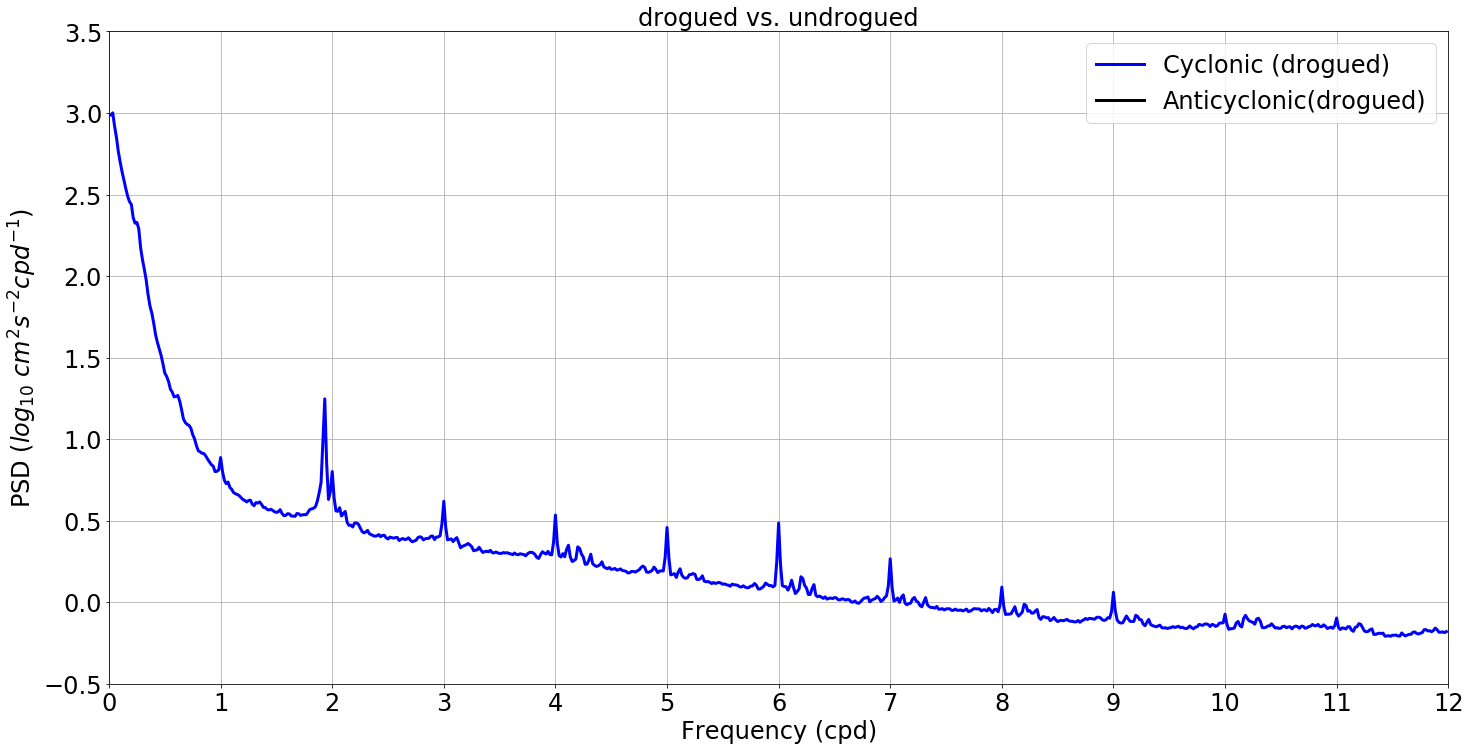

In [61]:
fig, ax = plt.subplots(figsize=(24,12))

labels = ['Cyclonic (drogued)', 'Anticyclonic(drogued)', 'Cyclonic (undrogued)', 'Anticyclonic(undrogued)']

# LLC4320
ax = plt.subplot(1,1,1)
np.log10(E_drifter_cycl_qd).plot(ax=ax, linewidth=3, color='blue', label=labels[0])
np.log10(E_drifter_anti_qd).plot(ax=ax, linewidth=3, color='black', label=labels[1])
#np.log10(E_drifter_cycl_qu).plot(ax=ax, linewidth=3, color='lightblue', label=labels[2])
#np.log10(E_drifter_anti_qu).plot(ax=ax, linewidth=3, color='blue', label=labels[3])
ax.legend(); ax.grid()
ax.set_ylim([-0.5,3.5])
ax.set_yticks([-0.5,0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5])
ax.set_xlim([0.,12.])
ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('drogued vs. undrogued',fontsize=24)


#plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_drogued_undrogued_globally_averaged.png')

In [28]:
uv_fft_complex = xrft.dft(ds.uv_drifters.where((ds.qd>0) & (ds.lat<62) & (ds.lat>7) & (ds.lon<360) & (ds.lon>263)).fillna(0.), dim=['time'], shift=False, detrend='constant', window=True, chunks_to_segments=False)
E_uv_blocks = (uv_fft_complex*uv_fft_complex.conj()).where(uv_fft_complex!=0., drop=False)/1440*3600
E_uv_blocks = np.real(E_uv_blocks).rename('E_uv_blocks')
E_uv_blocks = E_uv_blocks.assign_coords(freq_cpd=E_uv_blocks.freq_time * 86400.) 
print(E_uv_blocks)
file_E = data_dir+'E_drifter_uv_qd_blocks_Argos_North_Atlantic.zarr'
%time E_uv_blocks.to_dataset().to_zarr(file_E, mode='w')  

<xarray.DataArray 'E_uv_blocks' (lat: 132970, freq_time: 1440)>
array([[  41.449042,  224.213051,   18.733901, ...,   71.052559,  368.85104 ,
        1040.178246],
       [  71.514198,   78.044782,  180.974461, ...,  381.753522,  765.643948,
         319.976326],
       [ 536.502997, 2588.617917, 1703.104273, ...,   42.542534,  382.064573,
          64.560797],
       ...,
       [        nan,         nan,         nan, ...,         nan,         nan,
                nan],
       [        nan,         nan,         nan, ...,         nan,         nan,
                nan],
       [        nan,         nan,         nan, ...,         nan,         nan,
                nan]])
Coordinates:
  * lat                (lat) float64 44.22 44.91 44.86 43.76 42.22 46.44 ...
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
    freq_time_spacing  float64 1.929e-07
    freq_cpd           (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
CPU times: user 1.22 s, sys: 14

In [63]:
cluster.scheduler.close()

<Future finished result=None>